### Import required libraries

In [18]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

### Text Vectorization Layer
Create a dictionary of words and replace each word with its corresponding index in the dictionary. Text is being converted to lowercase with punctuations and noise in the text already removed. Text will be converted to a fixed lenght of 5.  

In [23]:
output_sequence_length = 5
vocab_size = 10
sentences = [['I really like you'], ['you like me too']]
sentence_data = Dataset.from_tensor_slices(sentences)

# Create TextVectorization layer
vectorize_layer = TextVectorization(
                    output_sequence_length=output_sequence_length,
                    max_tokens=vocab_size)

# Train layer to create dictionanry
vectorize_layer.adapt(sentence_data)

# convert all sentences to tensor
word_tensors = convert_to_tensor(sentences, dtype=tf.string)

# use the word tensors to get vectorized phases
vectorized_words = vectorize_layer(word_tensors)
print('Vocabulary: ', vectorize_layer.get_vocabulary())
print('Vectorized words: ', vectorized_words)

Vocabulary:  ['', '[UNK]', 'you', 'like', 'too', 'really', 'me', 'i']
Vectorized words:  tf.Tensor(
[[7 5 3 2 0]
 [2 3 6 4 0]], shape=(2, 5), dtype=int64)


### The Embedding Layer
This layer converts the vectorized integers to dense vectors by mapping the integers to random numbers which are  later tuned during the training stage. The maximum value of an integer to map, along with the length of the output sequence will be specified to initialize this layer.

In [25]:
output_length = 6
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words)

tf.Tensor(
[[[-2.2126008e-02 -3.7764598e-02  2.6047383e-02  2.9281747e-02
   -2.6089026e-02 -3.1630911e-02]
  [-1.0207761e-02  3.0542698e-02 -3.3656143e-02 -4.8206247e-02
   -4.5105603e-02 -2.3292959e-02]
  [-2.6548481e-02 -3.6362521e-03  1.3392415e-02 -1.6136743e-02
   -5.7589263e-05  2.2300053e-02]
  [ 3.7433717e-02 -2.0365894e-02 -3.5462558e-02  3.4051761e-03
    2.2094343e-02  2.2262085e-02]
  [-2.3195434e-02 -6.3557401e-03 -4.7489811e-02  4.5638468e-02
    4.5630667e-02 -2.8877009e-02]]

 [[ 3.7433717e-02 -2.0365894e-02 -3.5462558e-02  3.4051761e-03
    2.2094343e-02  2.2262085e-02]
  [-2.6548481e-02 -3.6362521e-03  1.3392415e-02 -1.6136743e-02
   -5.7589263e-05  2.2300053e-02]
  [ 4.5729470e-02 -4.2630423e-02  2.9843058e-02  3.6992822e-02
   -5.4129735e-03 -9.5288157e-03]
  [ 2.7218569e-02 -2.4116432e-02 -2.1551240e-02  4.3694463e-02
    7.1462393e-03  3.5072234e-02]
  [-2.3195434e-02 -6.3557401e-03 -4.7489811e-02  4.5638468e-02
    4.5630667e-02 -2.8877009e-02]]], shape=(2, 5, 6

### The Position Embeddings
The embeddings for the corresponding positions will be needed. The maximum positions correspond to the output sequence length of the TextVectorization layer.

In [26]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices)

tf.Tensor(
[[-0.0063786  -0.02739023 -0.03723443 -0.01768798  0.03711652  0.00513405]
 [-0.01952741 -0.02922603  0.00397249  0.00410565  0.03146471  0.0389826 ]
 [-0.02901748 -0.02447811 -0.04964608  0.01225094 -0.04306373  0.02616123]
 [ 0.04017119  0.04720197 -0.04679694  0.02926166 -0.0256608  -0.01286262]
 [-0.04167948 -0.03364266  0.02395311 -0.02478348 -0.02884538  0.013621  ]], shape=(5, 6), dtype=float32)


### Output of Positional Encoding in Transfromer Layers
Final output is the sum of both the word embeddings and the position embeddings. When setting up the embedding layers, the output length must be the same for both.

In [6]:
final_output_embedding = embedded_words + embedded_indices
print('Final output: ', final_output_embedding)

Final output:  tf.Tensor(
[[[-0.0355254   0.04209339  0.01560099  0.00301884  0.0708496
   -0.06040512]
  [-0.01940534 -0.02546074 -0.00463065  0.00063575  0.01455417
   -0.02913583]
  [-0.06205215  0.04625966 -0.0585547  -0.00262468 -0.03749379
    0.03159023]
  [ 0.00304055  0.00980653 -0.03997726 -0.01762348  0.00828151
    0.00290263]
  [ 0.00202781 -0.05798338  0.00062245 -0.02810565 -0.0104025
   -0.05959735]]

 [[-0.01446475 -0.02129437 -0.0007667  -0.02745466  0.06149679
   -0.05771731]
  [ 0.03943021  0.0227052   0.00389034  0.00843935  0.03654366
    0.00919087]
  [-0.03064502  0.00094226 -0.03857277 -0.07160868  0.01219207
    0.03110614]
  [-0.04478427  0.00989927 -0.01608056  0.02252822  0.00045188
   -0.0589138 ]
  [ 0.00202781 -0.05798338  0.00062245 -0.02810565 -0.0104025
   -0.05959735]]], shape=(2, 5, 6), dtype=float32)


### Subclassing the Keras Embedding Layer
Writing the position encoding layer for implementing the model.

In [11]:
class PositionEmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [12]:
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length,
                                            vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output)

Output from my_embedded_layer:  tf.Tensor(
[[[ 0.04623989  0.06670829 -0.02750586  0.06107529  0.05853873
    0.00839955]
  [-0.06119833  0.00973412  0.0334167   0.02901964 -0.02047502
    0.03735089]
  [-0.01794234  0.02338185 -0.0104884  -0.08032697 -0.03864441
   -0.05242062]
  [ 0.07136345  0.07789062  0.02154716  0.09063016 -0.01603872
    0.0358449 ]
  [ 0.02114854 -0.02630402  0.02361604 -0.01398748 -0.00175267
   -0.01119104]]

 [[ 0.03754658  0.07580233 -0.03903848  0.02713228  0.03204745
   -0.05183049]
  [-0.04418183 -0.01891258  0.05637662  0.00261655 -0.02037469
    0.00211183]
  [ 0.04906064  0.03102591  0.01584989  0.01187365 -0.01840589
   -0.01382619]
  [ 0.04723318  0.02041649 -0.02691056 -0.00567906 -0.05384922
   -0.02998375]
  [ 0.02114854 -0.02630402  0.02361604 -0.01398748 -0.00175267
   -0.01119104]]], shape=(2, 5, 6), dtype=float32)


### Positional Encoding in Transformers: Attention Is All You Need
Creating another positional embedding class that provides the positional encoding matrix as weights along with trainable=False.

In [13]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [14]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length,
                                            vocab_size, output_length)
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-0.9589243   1.2836622   0.23000172  1.9731903   0.01077196
    1.9999421 ]
  [ 0.56205547  1.5004725   0.3213085   1.9603932   0.01508068
    1.9999142 ]
  [ 1.566284    0.3377554   0.41192317  1.9433732   0.01938933
    1.999877  ]
  [ 1.0504174  -1.4061394   0.2314966   1.9860148   0.01077211
    1.9999698 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]

 [[ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [ 0.08466846 -0.11334133  0.23099795  1.9817369   0.01077207
    1.9999605 ]
  [ 1.8185948  -0.8322937   0.185397    1.9913884   0.00861771
    1.9999814 ]
  [ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]], shape=(2, 5, 6), dtype=float32)


### Visualizing the Final Embedding
For visualization purpose, two sentences longer than the initial ones will be used nmaely - life_phrase and philosophical_phrase. TextVectorization layer along with the positional encoding layer will be set up. 

In [29]:
life_phrase = "the outer world is a reflection of the inner world " +\
                   " other people's perception of you is a reflection of them "+\
                   "your response to them is an awareness of you"
philosophical_phrase = "be the reason someone smiles "+\
                       "be the reason someone feels loved and believes in the goodness in people"
 
total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([life_phrase, philosophical_phrase])
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([life_phrase, philosophical_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)
 
random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

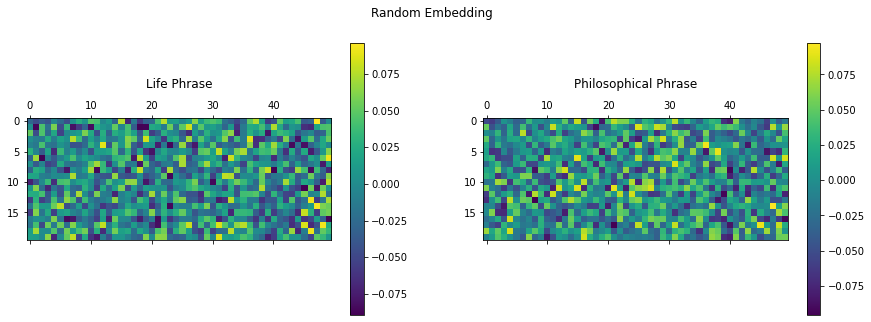

In [30]:
fig = plt.figure(figsize=(15, 5))    
title = ["Life Phrase", "Philosophical Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

### Visualization from the Embedding Fixed Weight Layer
As will be shown, the fixed weights generated using sinusoids creates a unique signature for every phrase with information on each word position encoded within it.

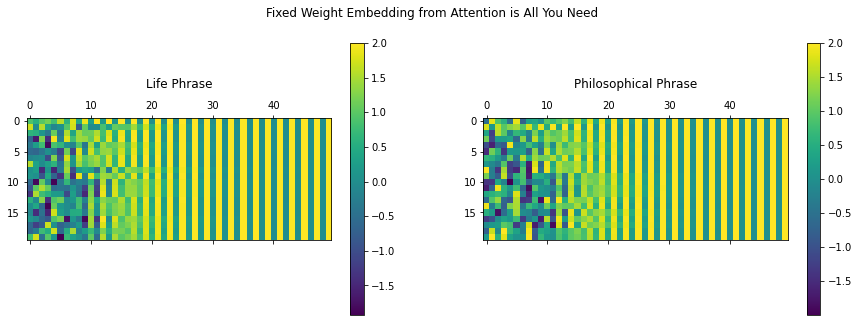

In [31]:
fig = plt.figure(figsize=(15, 5))    
title = ["Life Phrase", "Philosophical Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()